In [17]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from modules.moving_averages import detrend_signal

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
from scipy.spatial.distance import cdist

def proximity_to_genotype(cells, cell_type, min_population=10):
    genotype = cells[cells.cell_type==cell_type]
    if len(genotype) > min_population:
        rs = lambda x: x.centroid_x.values.reshape(-1, 1)
        distances = cdist(rs(cells), rs(genotype)).min(axis=1)   
    else:
        distances = 1000*np.ones(len(cells), dtype=np.float64)
    return distances

from collections import Counter

def resample(cells, size=None, cutoff=None):
    """ Resample uniformly in X. """
    
    # sort values
    x = cells.sort_values('centroid_x')['centroid_x']
    
    if size is None:
        size = len(x)
        
    # apply threshold on upper bound
    if cutoff is not None:
        threshold = np.percentile(x.values, cutoff)
    else:
        threshold = x.max()+1

    # get unique x values
    xunique = np.unique(x.values)

    # filter points below threshold
    xx = x[x<=threshold]

    # get probabilities
    x_to_count = np.vectorize(Counter(xx).get)

    # get intervals
    intervals = np.diff(xunique)
    unique_below_threshold = (xunique[:-1]<=threshold)
    intervals = intervals[unique_below_threshold]
        
    # assign probabilities
    x_to_cumul = np.vectorize(dict(zip(xunique[:-1][unique_below_threshold], intervals/intervals.sum())).get)
    
    p = x_to_cumul(xx)/x_to_count(xx)
    
    p[np.isnan(p)] = 0

    # generate sample
    sample_ind = np.random.choice(xx.index, size=size, p=p)
    #xu, yu = xx[sample_ind], yy[sample_ind]

    return cells.loc[sample_ind] 

def resample_df(df, size=None):
    """ Resample dataframe uniformly in X """

    # resample all
    resampled = []
    for exp_id in df.experiment.unique():
        exp = df[df.experiment==exp_id]
        for disc_id in exp.disc_id.unique():
            disc = exp[exp.disc_id==disc_id]
            for layer_id in disc.layer.unique():
                layer = disc[disc.layer==layer_id]
                for genotype in (0, 1, 2):
                    cells = layer[layer.genotype==genotype] 
                    if len(cells) > 5:
                        resampled_cells = resample(cells, size=size)
                    resampled.append(resampled_cells)
    resampled = pd.concat(resampled)
    return resampled

import seaborn as sns
from copy import deepcopy

def stripplot(df, y='red'):
    plt.figure()
    order = ('control', 'perturbation')
    hue_order = ('0x yan', '1x yan', '2x yan')
    sns.stripplot(x='experiment', y=y, data=df, order=order, hue='cell_type', hue_order=hue_order, dodge=True)
    ax = plt.gca()
    ax.legend(loc=1)
    ax.grid(axis='y')

def boxplot(df, y='red'):
    plt.figure()
    order = ('control', 'perturbation')
    hue_order = ('0x yan', '1x yan', '2x yan')
    sns.boxplot(x='experiment', y=y, data=df, order=order, hue='cell_type', hue_order=hue_order, notch=True)
    ax = plt.gca()
    ax.legend(loc=1)
    ax.grid(axis='y')
    
def violinplot(df, y='red'):
    plt.figure()
    order = ('control', 'perturbation')
    hue_order = ('0x yan', '1x yan', '2x yan')
    sns.violinplot(x='experiment', y=y, data=df, order=order, hue='cell_type', hue_order=hue_order)
    ax = plt.gca()
    ax.legend(loc=1)
    ax.grid(axis='y')
    
def swarmplot(df, y='red'):
    plt.figure()
    order = ('control', 'perturbation')
    hue_order = ('0x yan', '1x yan', '2x yan')
    sns.swarmplot(x='experiment', y=y, data=df, order=order, hue='cell_type', hue_order=hue_order)
    ax = plt.gca()
    ax.legend(loc=1)
    ax.grid(axis='y')
    
def pairplot(df, y='red'):
    plt.figure(figsize=(2, 4))
    order = sorted(df.experiment.unique())
    hue_order = sorted(df.cell_type.unique())
    sns.violinplot(x='experiment', y=y, data=df, order=order, hue='cell_type', hue_order=hue_order)
    #sns.boxplot(x='experiment', y=y, data=df, order=order, hue='cell_type', hue_order=hue_order, notch=True)
    ax = plt.gca()
    ax.legend(loc=1)
    ax.grid(axis='y')
    _ = ax.set_ylim(-0.3, 2)
    
def compare(df, x='control_m', y='control_h', basis='green_corrected', plot=True):
    keys = {'mhw'[i]: ct for i, ct in enumerate(('0x yan', '1x yan', '2x yan'))}
    exp0, g0 = x.split('_')
    exp1, g1 = y.split('_')
    
    # select concurrent cell populations
    if exp0 == exp1:
        pop = df[df['concurrent_'+x[-1]+y[-1]]]
    else:
        pop = df
        
    p0 = pop[np.logical_and(pop.experiment==exp0, pop.cell_type==keys[g0])]
    p1 = pop[np.logical_and(pop.experiment==exp1, pop.cell_type==keys[g1])]
    
    ks, p_ks = ks_2samp(p0[basis].values, p1[basis].values)
    t, p_t = ttest_ind(p0[basis].values, p1[basis].values)
    k_mw, p_mw = mannwhitneyu(p0[basis].values, p1[basis].values, alternative='two-sided')
    
    if plot:
        _ = pairplot(pd.concat([p0, p1]), basis)
    
    return p_ks, p_t, p_mw

from scipy.stats import ks_2samp, ttest_ind
from scipy.stats import mannwhitneyu
def summary(df, basis='green_corrected', plot=False):
    
    kw = dict(basis=basis, plot=plot)

    ks_c_mh, t_c_mh, mw_c_mh = compare(df, 'control_m', 'control_h', **kw)
    ks_c_hw, t_c_hw, mw_c_hw = compare(df, 'control_h', 'control_w', **kw)
    ks_p_mh, t_p_mh, mw_p_mh = compare(df, 'perturbation_m', 'perturbation_h', **kw)
    ks_p_hw, t_p_hw, mw_p_hw = compare(df, 'perturbation_h', 'perturbation_w', **kw)
    ks_p_mw, t_p_mw, mw_p_mw = compare(df, 'perturbation_m', 'perturbation_w', **kw)
    ks_cross, t_cross, mw_cross = compare(df, 'control_m', 'perturbation_h', **kw)

    print('KS tests')
    print('Control Mut vs Het: {:0.8f}'.format(ks_c_mh))
    print('Control Het vs WT: {:0.8f}'.format(ks_c_hw))
    print('Perturbation Mut vs Het: {:0.8f}'.format(ks_p_mh))
    print('Perturbation Het vs WT: {:0.8f}'.format(ks_p_hw))
    print('Perturbation Mut vs WT: {:0.8f}'.format(ks_p_mw))
    print('Control Mut vs Perturbation WT: {:0.8f}'.format(ks_cross))

#     print('\n t-tests')
#     print('Control Mut vs Het: {:0.8f}'.format(t_c_mh))
#     print('Control Het vs WT: {:0.8f}'.format(t_c_hw))
#     print('Perturbation Mut vs Het: {:0.8f}'.format(t_p_mh))
#     print('Perturbation Het vs WT: {:0.8f}'.format(t_p_hw))
#     print('Control Mut vs Perturbation WT: {:0.8f}'.format(t_cross))
    
    print('\n MW-tests')
    print('Control Mut vs Het: {:0.8f}'.format(mw_c_mh))
    print('Control Het vs WT: {:0.8f}'.format(mw_c_hw))
    print('Perturbation Mut vs Het: {:0.8f}'.format(mw_p_mh))
    print('Perturbation Het vs WT: {:0.8f}'.format(mw_p_hw))
    print('Perturbation Mut vs WT: {:0.8f}'.format(mw_p_mw))
    
    print('Control Mut vs Perturbation WT: {:0.8f}'.format(mw_cross))

In [26]:
# Load data
data_path = '../data/clean_data.json'
with open(data_path, 'r') as f:
    df = pd.read_json(f)
        
df = df[df.genotype.isin((0,1,2))]
df['red'] = df.r / df.b 
df['green_corrected'] = (df.g - df.gp) / df.b
df['cell_type'] = np.vectorize({0:'0x yan', 1:'1x yan', 2:'2x yan'}.get)(df.genotype)

for exp_id in df.experiment.unique():
    exp = df[df.experiment==exp_id]
    for disc_id in exp.disc_id.unique():
        disc = exp[exp.disc_id==disc_id]
        for layer_id in disc.layer.unique():
            layer = disc[disc.layer==layer_id]
        
            cells = layer.sort_values('centroid_x')                
            for l, cell_type in enumerate(('0x yan', '1x yan', '2x yan')):
                df.loc[cells.index, 'distance_'+'mhw'[l]] = proximity_to_genotype(cells, cell_type)      
                     
            window_size = 25
            residuals, trend = detrend_signal(cells.green_corrected, window_size=window_size)
            df.loc[cells.index, 'gc_detrended'] = residuals/trend
            
# define concurrency
tol = 10
for cell_type in 'mhw':
    df['concurrent_'+cell_type] = df['distance_'+cell_type] <= tol

df['concurrent_mh'] = df.concurrent_m & df.concurrent_h 
df['concurrent_hw'] = df.concurrent_h & df.concurrent_w
df['concurrent_mw'] = df.concurrent_m & df.concurrent_w
df['concurrent_all'] = df.concurrent_m & df.concurrent_h & df.concurrent_w

print('before', len(df))
df = df[~df.boundary]
#df = df[df.concurrent_all]
#resampled = resample_df(df)
print('after', len(df))

before 36112
after 24921


In [27]:
summary(df, basis='gc_detrended', plot=False)

KS tests
Control Mut vs Het: 0.36693696
Control Het vs WT: 0.05233702
Perturbation Mut vs Het: 0.00000000
Perturbation Het vs WT: 0.00000000
Perturbation Mut vs WT: 0.00000000
Control Mut vs Perturbation WT: 0.00015098

 MW-tests
Control Mut vs Het: 0.23712153
Control Het vs WT: 0.02520304
Perturbation Mut vs Het: 0.00000000
Perturbation Het vs WT: 0.00000000
Perturbation Mut vs WT: 0.00000000
Control Mut vs Perturbation WT: 0.00012705


Text(0,0.5,'GFP level (corrected)')

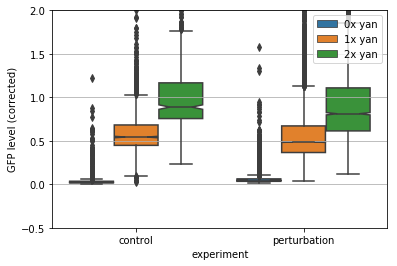

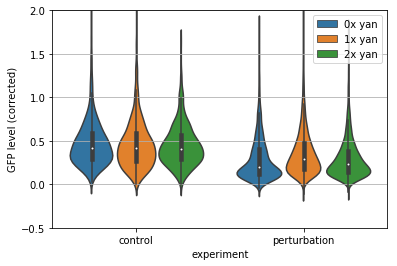

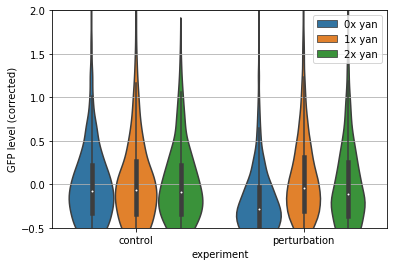

In [25]:
boxplot(df, 'red')
ax = plt.gca()
_ = ax.set_ylim(-0.5, 2.)
ax.set_ylabel('GFP level (corrected)')

violinplot(df, 'green_corrected')
ax = plt.gca()
_ = ax.set_ylim(-0.5, 2.)
ax.set_ylabel('GFP level (corrected)')

violinplot(df, 'gc_detrended')
ax = plt.gca()
_ = ax.set_ylim(-0.5, 2.)
ax.set_ylabel('GFP level (corrected)')

In [119]:
exp = df[df.experiment=='perturbation']

In [137]:
a = 0
for pop in exp.groupby(('disc_id')):
    disc = pd.DataFrame.from_records(pop[1])
    

In [22]:
from scipy.stats import pearsonr

In [23]:
control = resampled[resampled.experiment=='control']
mutant = resampled[resampled.experiment=='perturbation']

NameError: name 'resampled' is not defined

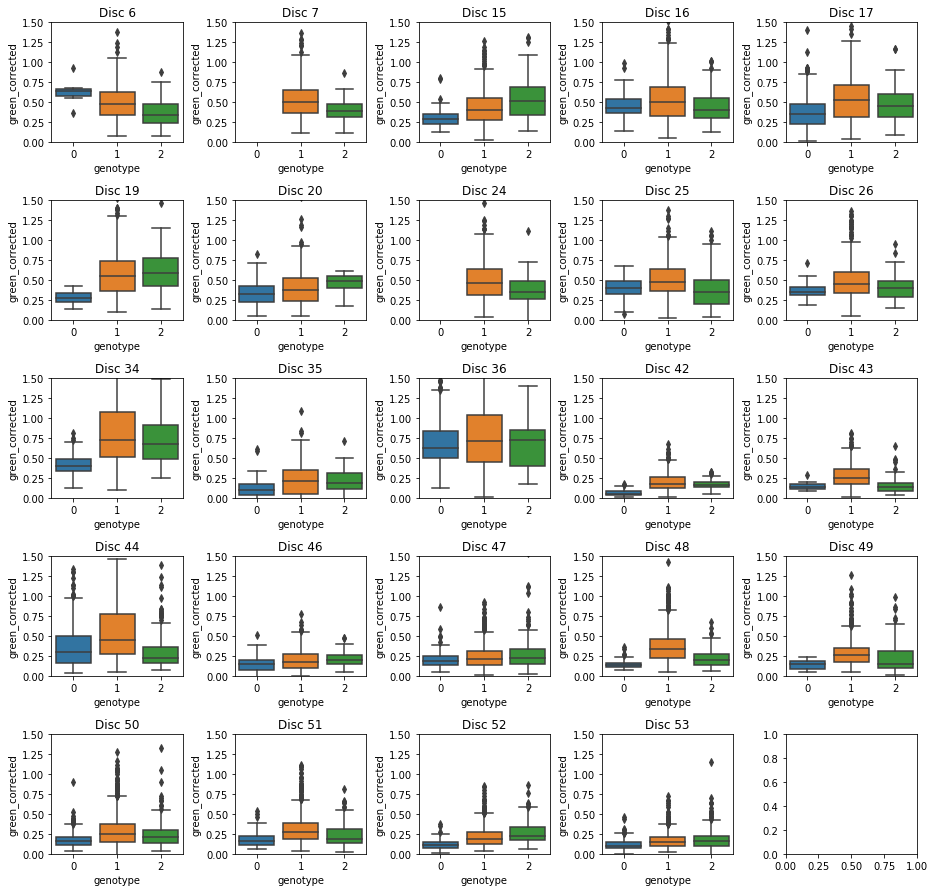

In [28]:
exp = df[df.experiment=='perturbation']
gb = exp.groupby(by=('disc_id'))
nlayers = len(gb.indices)
nrows = (nlayers // 5)+1
fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(13, nrows*2.5))
for i, ind in enumerate(gb.indices.values()):
    ax = axes.ravel()[i]
    cells = exp.iloc[ind]
    
    sns.boxplot(x='genotype', y='green_corrected', data=cells, order=(0,1,2),  ax=ax)
    #sns.violinplot(x='genotype', y='green_corrected', data=cells, order=(0,1,2),  ax=ax)
    
    disc_id = cells.disc_id.unique()[0]
    ax.set_title('Disc {}'.format(disc_id))
    ax.set_ylim(0, 1.5)
    
plt.tight_layout()

In [7]:
""" Detrending about resampled trend """

' Detrending about resampled trend '

In [ ]:
from modules.moving_averages import savgol_filter, get_running_mean
from scipy.interpolate import interp1d

def fit_trendline(cells, size=100000):
    try:
        pop = [resample(cells[cells.genotype==g], size=size) for g in cells.genotype.unique()]
    except:
        print(len(cells[cells.genotype==0]))
        print(len(cells[cells.genotype==1]))
        print(len(cells[cells.genotype==2]))
    mix = pd.concat(pop)
    mix = mix.sort_values('centroid_x')
    #ma = savgol_filter(mix.green_corrected, size+1, 3)
    window_size = int((size*3)/5)
    ma_x = get_running_mean(mix.centroid_x.values, window_size=window_size)
    ma_y = get_running_mean(mix.green_corrected.values, window_size=window_size)
    trend = interp1d(ma_x, ma_y, bounds_error=False, fill_value=(ma_y[0], ma_y[-1]))
    return trend

for exp_id in df.experiment.unique():
    exp = df[df.experiment==exp_id]
    for disc_id in exp.disc_id.unique():
        disc = exp[exp.disc_id==disc_id]
        for layer_id in disc.layer.unique():
            layer = disc[disc.layer==layer_id]
            cells = layer.sort_values('centroid_x')                
            model = fit_trendline(cells)
            trend = model(cells.centroid_x)
            
#             fig, ax = plt.subplots()
#             ax.plot(cells.centroid_x, trend, '-r')
#             ax.set_ylim(0, 2)
#             ax.scatter(cells.centroid_x, cells.green_corrected, s=1)
            
            residuals = cells.green_corrected - trend
            df.loc[cells.index, 'gc_residuals_res'] = residuals
            df.loc[cells.index, 'gc_detrended_res'] = residuals / trend

# Figures

In [61]:
tickpad = 0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['xtick.major.pad'] = tickpad
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['ytick.major.pad'] = tickpad
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['ytick.direction'] = 'out'

In [65]:
control = df[df.experiment=='control']
mutant = df[df.experiment=='perturbation']

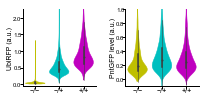

In [68]:
fig = statistics_figure(mutant, variable='green_corrected')
#fig.savefig('../graphics/statistics_perturbation.pdf', dpi=300, format='pdf', transparent=True, rasterized=False)

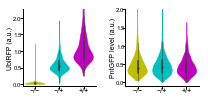

In [83]:
fig = statistics_figure(control, variable='green_corrected')
#fig.savefig('../graphics/statistics_control.pdf', dpi=300, format='pdf', transparent=True, rasterized=False)

In [82]:
def statistics_figure(df, variable='green_corrected'):

    # create axes and define colors
    fig, axes = plt.subplots(ncols=2, figsize=(3, 1.5))
    ax0, ax1 = axes

    kw = dict(scale='width', cut=0)

    # add UbiRFP strip plot
    comparison_plot(df, ax0, groupby='genotype', variable='red', 
               ymax=2.25, statistics=False, markersize=1.5, **kw)
    ax0.set_ylabel('UbiRFP (a.u.)', fontsize=7)

    # add PntGFP strip plot
    comparison_plot(df, ax1, groupby='genotype', variable=variable, 
               ymin=-0.1, ymax=2., markersize=1.25, **kw)
    ax1.set_ylabel('PntGFP level (a.u.)', fontsize=7)

    for ax in axes:
        ax.tick_params(axis='x', labelsize=7, pad=-2)
        ax.tick_params(axis='y', labelsize=6, pad=-2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    return fig

In [64]:
def get_asterisks(p):
    stars = np.floor(-np.log10(p)-1).astype(int) * '*'
    if len(stars) > 4:
        stars = stars[:4]
    return stars

def comparison_plot(df, ax, groupby='genotype', variable='red', 
                    ymin=-0.05, ymax=1.75, markersize=3, statistics=True, **kw):
    
    # set labels and colors
    labels = {0:'−/−', 1:'−/+', 2:'+/+'}
    colors = {0:'y', 1:"c", 2:"m"}

    # plot distribution of RFP levels, separated by assigned label
    order=(0, 1, 2)
    #sns.boxplot(x=groupby, y=variable, data=df, order=order, ax=ax, linewidth=0.5, fliersize=0, notch=True)
    sns.violinplot(x='genotype', y=variable, data=df, order=order, ax=ax, linewidth=0.5, fliersize=0, **kw)
    #sns.stripplot(x='genotype', y=variable, data=df, order=order, ax=ax, jitter=.3, size=markersize)
    
    # format ticklabels as genotypes
    polycollections = [c for c in ax.collections if c.__class__.__name__ == 'PolyCollection']
    ticklabels = []
    for i, label in enumerate(ax.get_xticklabels()):
        color = colors[int(label.get_text()[0])]
        
        polycollections[i].set_color(color)
        #ax.collections[i].set_color(color)
        
        #ax.artists[i].set_facecolor(color)
        label.set_text(labels[int(label.get_text()[0])])
        ticklabels.append(label)
        
    _ = ax.set_xticklabels(ticklabels, ha='center')
    ax.tick_params(axis='both', pad=3)
    ax.set_xlabel('')
    ax.set_ylim(ymin, ymax)
    
#     # statistical testing for whether distributions are the same
#     if statistics:
        
#         # get groups
#         m = precursors[precursors[groupby]=='m']
#         h = precursors[precursors[groupby]=='h']
#         w = precursors[precursors[groupby]=='w']
        
#         # perform statistical comparisons using KS 2-sample test
#         ks0, p0 = ks_2samp(m[variable], h[variable])
#         ks1, p1 = ks_2samp(h[variable], w[variable])
#         print(p0, p1)
        
#         # add stars to plot
#         star_pos = ax.get_xticks()[:-1] + np.diff(ax.get_xticks())/2
#         for pos, p in zip(star_pos, (p0, p1)):
#             ax.text(pos, .8*(ymax-ymin) + ymin, get_asterisks(p), ha='center', fontsize=12)        
    

In [77]:
# Load paths to each set of experiments
from modules.paths import Experiment
mutant_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/slices/w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
mutant = Experiment(mutant_path)

In [78]:
stack = mutant[mutant.disc_names.index(42)]
layer = stack[3]

In [79]:
exp = df[df.experiment=='perturbation']
disc = exp[exp.disc_id==42]
cells = disc[disc.layer==3]

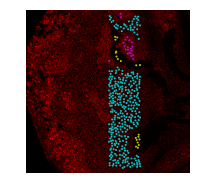

In [81]:
# create axis
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize=(3, 3))
_ = layer.get_channel('r').show(ax=ax, segments=False, cmap=None)
_ = ax.axis('off')
cmap = ListedColormap(['y', 'c', 'm'], 'indexed', 3)


ax.scatter(cells.centroid_x, cells.centroid_y, c=cells.genotype, cmap=cmap, vmin=0, vmax=2, s=1)

fig.savefig('../graphics/cells_included.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)

In [89]:
tickpad = 0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['xtick.major.pad'] = tickpad
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['ytick.major.pad'] = tickpad
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['ytick.direction'] = 'out'

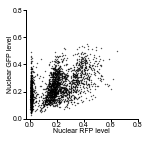

In [103]:
exp = df[df.experiment=='control']

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(exp.r, exp.g, s=0.1, c='k')
_ = ax.set_xticks(np.arange(0, .95, .2))
_ = ax.set_yticks(np.arange(0, .95, .2))
_ = ax.set_xlabel('Nuclear RFP level', fontsize=7)
_ = ax.set_ylabel('Nuclear GFP level', fontsize=7)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)

#fig.savefig('../graphics/control_correlation.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)

In [112]:
exp = df[df.experiment=='control']

In [ ]:
36  23

10 6


In [114]:
len(exp.disc_id.unique())

6

In [113]:
exp.groupby(('disc_id', 'layer')).count()

b  b_std  boundary  centroid_x  centroid_y  disc_genotype  \
disc_id layer                                                                
28      0      392    392       392         392         392            392   
        2      400    400       400         400         400            400   
29      0      186    186       186         186         186            186   
        1      239    239       239         239         239            239   
30      0      253    253       253         253         253            253   
        1      151    151       151         151         151            151   
31      0      369    369       369         369         369            369   
55      0      221    221       221         221         221            221   
        4      212    212       212         212         212            212   
56      1      156    156       156         156         156            156   

               experiment  foreground    g  g_corrected       ...        \
disc_id layer                                                 ...         
28      0             392         392  392          392       ...         
        2             400         400  400          400       ...         
29      0             186         186  186          186       ...         
        1             239         239  239          239       ...         
30      0             253         253  253          253       ...         
        1             151         151  151          151       ...         
31      0             369         369  369          369       ...         
55      0             221         221  221          221       ...         
        4             212         212  212          212       ...         
56      1             156         156  156          156       ...         

               distance_h  distance_w  gc_detrended  concurrent_m  \
disc_id layer                                                       
28      0             392         392           392           392   
        2             400         400           400           400   
29      0             186         186           186           186   
        1             239         239           239           239   
30      0             253         253           253           253   
        1             151         151           151           151   
31      0             369         369           369           369   
55      0             221         221           221           221   
        4             212         212           212           212   
56      1             156         156           156           156   

               concurrent_h  concurrent_w  concurrent_mh  concurrent_hw  \
disc_id layer                                                             
28      0               392           392            392            392   
        2               400           400            400            400   
29      0               186           186            186            186   
        1               239           239            239            239   
30      0               253           253            253            253   
        1               151           151            151            151   
31      0               369           369            369            369   
55      0               221           221            221            221   
        4               212           212            212            212   
56      1               156           156            156            156   

               concurrent_mw  concurrent_all  
disc_id layer                                 
28      0                392             392  
        2                400             400  
29      0                186             186  
        1                239             239  
30      0                253             253  
        1                151             151  
31      0                369             369  
55      0                2